In [46]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [8]:
import os
import logging as log
from torch import nn, optim
import torch.nn.functional as F

from constants.date_time import DatetimeFreq
from utils.data_processing import *
from logger.logger import setup_logging
from utils.utils import get_data_sub_paths

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from trainers.generic_trainer import train_model
from utils.configs import BaseConf
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import save_metrics, compare_all_models
from pprint import pprint

In [10]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))

data_sub_path = 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'

array(['T12H-X850M-Y880M_2013-01-01_2017-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
       'T24H-X1275M-Y1320M_2012-01-01_2019-01-01',
       'T24H-X1700M-Y1760M_2012-01-01_2019-01-01',
       'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97',
       'T24H-X255M-Y220M_2013-01-01_2017-01-01',
       'T24H-X425M-Y440M_2012-01-01_2019-01-01',
       'T24H-X425M-Y440M_2013-01-01_2017-01-01',
       'T24H-X850M-Y880M_2012-01-01_2019-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2017-01-01',
       'T3H-X850M-Y880M_2013-01-01_2017-01-01',
       'T6H-X850M-Y880M_2013-01-01_2017-01-01'], dtype='<U43')


In [11]:
conf = BaseConf()

conf.use_periodic_average = True
conf.use_classification = False
conf.use_crime_types = False

conf.seed = 3  #int(time())  # idea is to have a constant seed while changing hyperparameters

conf.pad_with = 3
conf.seq_len = 14

# conf.model_name = "LR (CMP)"
conf.model_name = f"LR (CMP) (pad={conf.pad_with},seq_len={conf.seq_len})"

if conf.use_periodic_average:
    conf.model_name = f"{conf.model_name} (HistAvg)"

# conf.model_name = "LR (CMP+HistAvg)"
# conf.model_name = "LR (CMP)"
# conf.model_name = "LR (TMP)"
# conf.model_name = "LR (SPC)" # demog
# conf.model_name = "LR (ENV)"  # google street view

if conf.use_crime_types:
    conf.model_name = f"{conf.model_name} (crime-types)"

if not conf.use_classification:
    conf.model_name = f"{conf.model_name} (rgr)"
else:
    conf.model_name = f"{conf.model_name} (cls)"

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# SET NUMPY AND TORCH SEEDS LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

# SET THE hyperparameterS
conf.resume = True
conf.early_stopping = True
conf.max_epochs = 20
conf.dropout = 0  #0.2
conf.weight_decay = 1e-6  #1e-8#0
conf.checkpoint = "best"  # ["best"|"latest"]
conf.lr = 1e-3
conf.batch_size = 64

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 1  # 0 #
conf.sub_sample_validation_set = 1  # 0 #

data_group = CellDataGroup(data_path=conf.data_path, conf=conf)
loaders = CellDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = DatetimeFreq.convert(data_group.t_range)

2020-09-24T10:28:19 | root | INFO | Device: cuda:0
2020-09-24T10:28:19 | root | INFO | 	t_range shape (2558,)
fitted periodic average: step (1) and max_steps (-1)


In [12]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()

        self.name = "LogReg"
        self.linear = nn.Linear(input_size, output_size)

        self.sigmoid = nn.Sigmoid()  # ensures output values always between one and zero

    def forward(self, x):
        out = self.linear(x)

        if not conf.use_classification:
            out = self.sigmoid(out)

        return out


class LogisticRegression3(nn.Module):
    def __init__(self, spc_size, tmp_size, env_size, output_size):
        super(LogisticRegression3, self).__init__()

        self.name = "LogReg3"
        self.lin_spc = nn.Linear(spc_size, output_size)
        self.lin_tmp = nn.Linear(tmp_size, output_size)
        self.lin_env = nn.Linear(env_size, output_size)
        self.lin_all = nn.Linear(3 * output_size, output_size)

    def forward(self, spc_feats, tmp_feats, env_feats):
        out_cat = torch.cat([self.lin_spc(spc_feats),
                             self.lin_tmp(tmp_feats),
                             self.lin_env(env_feats)], dim=-1)
        out_all = self.lin_all(out_cat)

        if not conf.use_classification:
            out_all = self.sigmoid(out_all)

        return out_all

In [13]:
# Model setup  
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

tmp_size = tmp_size * train_set.seq_len

if conf.use_classification:
    output_size = 2
    loss_function = nn.CrossEntropyLoss()
else:
    output_size = 1
    loss_function = nn.MSELoss()

model = LogisticRegression(input_size=spc_size + tmp_size + env_size,
                           output_size=output_size)

# model = LogisticRegression3(spc_size=spc_size,
#                             tmp_size=tmp_size,
#                             env_size=env_size,
#                             output_size=2)

model.to(conf.device)

parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validation score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict)

        # new optimiser hyperparameters
    #         optimiser.param_groups[0]['lr'] = conf.lr
    #         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

RuntimeError: CUDA error: unknown error

In [ ]:
def train_epoch_for_log_reg(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    epoch_losses = []
    num_batches = batch_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
        current_batch = batch_loader.current_batch

        # reformat for model input
        tmp_feats = np.swapaxes(tmp_feats, 0, 1)
        tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0], -1))
        spc_feats = spc_feats[-1]
        env_feats = env_feats[-1]
        cmp_feats = np.concatenate((spc_feats, tmp_feats, env_feats), axis=-1)
        targets = targets[-1]

        # Transfer to PyTorch Tensor and GPU
        cmp_feats = torch.Tensor(cmp_feats).to(conf.device)

        #         spc_feats = torch.Tensor(spc_feats).to(conf.device)
        #         tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        #         env_feats = torch.Tensor(env_feats).to(conf.device)

        if conf.use_classification:
            targets = torch.LongTensor(targets[:, 0]).to(conf.device)
        else:
            targets = torch.Tensor(targets).to(conf.device)  # do not add [:,0]

        out = model(cmp_feats)
        #         out = model(spc_feats)
        #         out = model(tmp_feats)
        #         out = model(env_feats)
        #         out = model(spc_feats=spc_feats,
        #                     tmp_feats=tmp_feats,
        #                     env_feats=env_feats)

        loss = loss_fn(input=out, target=targets)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])

        if model.training:  # not used in validation loops
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    return mean_epoch_loss


def evaluate_log_reg(model, batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch

            # reformat for model input
            tmp_feats = np.swapaxes(tmp_feats, 0, 1)
            tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0], -1))
            spc_feats = spc_feats[-1]
            env_feats = env_feats[-1]
            cmp_feats = np.concatenate((spc_feats, tmp_feats, env_feats), axis=-1)
            targets = targets[-1, :, 0]

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(cmp_feats).to(conf.device)

            # used for log_reg_3
            spc_feats = torch.Tensor(spc_feats).to(conf.device)
            tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
            env_feats = torch.Tensor(env_feats).to(conf.device)

            out = model(cmp_feats)
            #             out = model(tmp_feats)
            #             out = model(env_feats)
            #             out = model(spc_feats=spc_feats,
            #                         tmp_feats=tmp_feats,
            #                         env_feats=env_feats)

            if conf.use_classification:
                batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction
            else:
                batch_probas_pred = out.cpu().numpy()

            for i, p in zip(indices, batch_probas_pred):
                n, c, h, w = i
                probas_pred[n, c, h, w] = p

    return y_true, probas_pred, t_range

## Training

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimiser, 'min')
type(scheduler)

torch.optim.lr_scheduler.ReduceLROnPlateau

In [ ]:

N = 10
D = 1
s = 1
x = np.random.randn(N, D)
y = np.random.randn(N, D)

2020-08-24T18:00:33 | root | INFO | 
 ====================== Training LR (CMP) (pad=3,seq_len=14) (HistAvg) (rgr) ====================== 

2020-08-24T18:00:33 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 20,
 'model_name': 'LR (CMP) (pad=3,seq_len=14) (HistAvg) (rgr)',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/models/LR '
               '(CMP) (pad=3,seq_len=14) (HistAvg) (rgr)/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'pad_with': 3,
 'resume': True,
 'seed': 3,
 'seq_len': 14,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': 0,
 'sub_sample_train_se

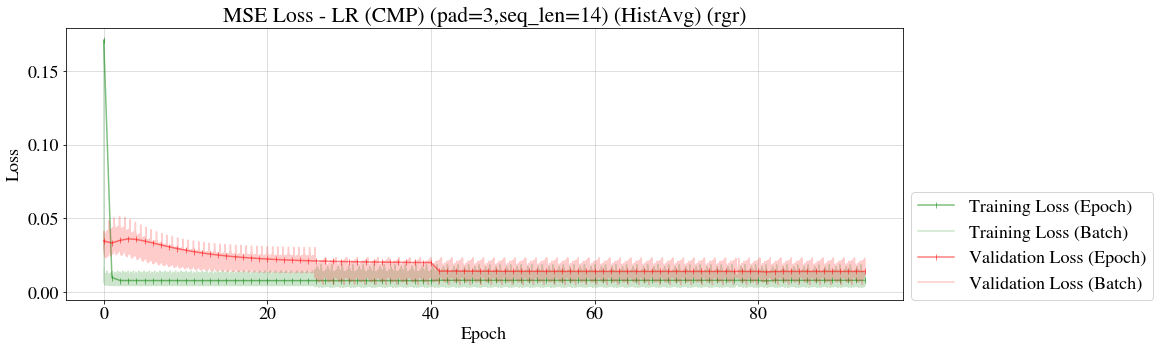

In [8]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_log_reg,
    loss_fn=loss_function,
    conf=conf,
    scheduler=scheduler,
)

In [173]:
stopped_early

True

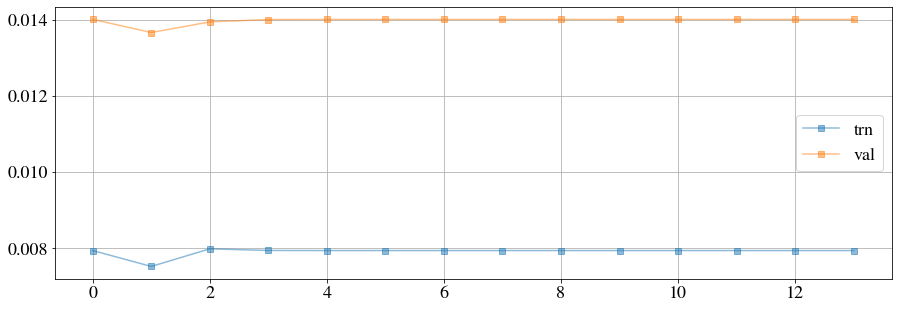

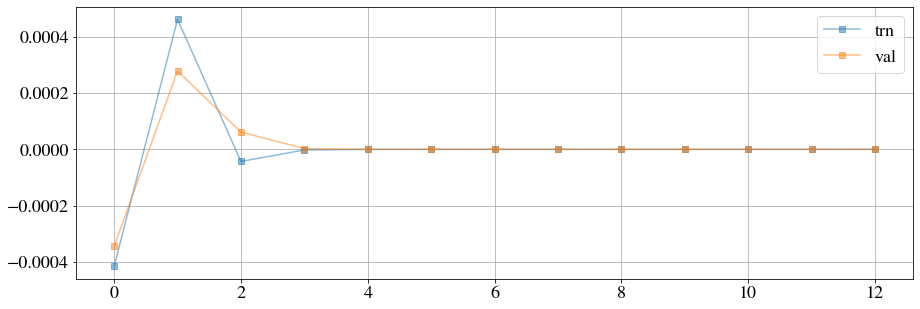

In [163]:
lim = 14

plt.figure(figsize=(15, 5))
for x, label in zip([trn_epoch_losses, val_epoch_losses], ['trn', 'val']):
    plt.plot(x[-lim:], marker='s', alpha=.5, label=label)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for x, label in zip([trn_epoch_losses, val_epoch_losses], ['trn', 'val']):
    plt.plot(np.diff(x[-lim:]), marker='s', alpha=.5, label=label)
plt.grid(True)
plt.legend()
plt.show()

## Evaluation

In [98]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validation score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                              map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2020-08-24T15:07:15 | root | INFO | Loading model from checkpoint (best) for evaluation


<All keys matched successfully>

In [99]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = CellDataLoaders(data_group=data_group, conf=conf)

In [129]:
# todo set the train_loader to eval so that it does not subsample
trn_y_true, trn_probas_pred, trn_t_range = evaluate_log_reg(model=model,
                                                            batch_loader=loaders.train_loader,
                                                            conf=conf)

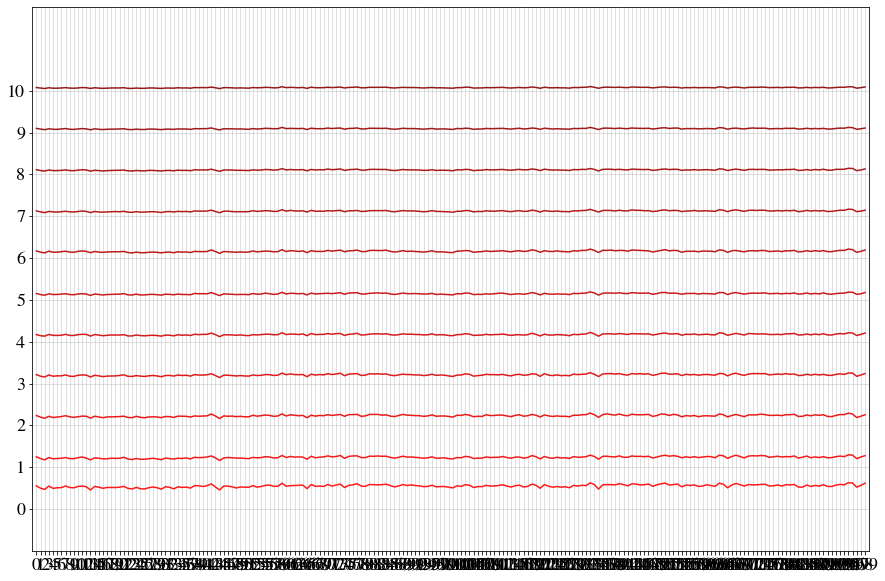

In [130]:
a = data_group.shaper.squeeze(trn_probas_pred)[:, 0, data_group.sorted_indices]  # N, C, L
# a = data_group.shaper.squeeze(trn_y_true)[:,0,data_group.sorted_indices]
lim = a.shape[0]
a = a[:lim, 0:-1:70]

plt.figure(figsize=(15, 10))
I = a.shape[-1]

for i in range(I):
    r = 1 - (0.5 * (i) / (I + 1))
    b = .1
    g = .1
    c = (r, .1, .1)
    plt.plot(a[:, i] + i, c=c)

plt.xlim(-1, len(a))
plt.ylim(-1, I + 1)
plt.yticks(np.arange(a.shape[-1]))
plt.xticks(np.arange(lim))
plt.grid(True, alpha=.5)
plt.show()

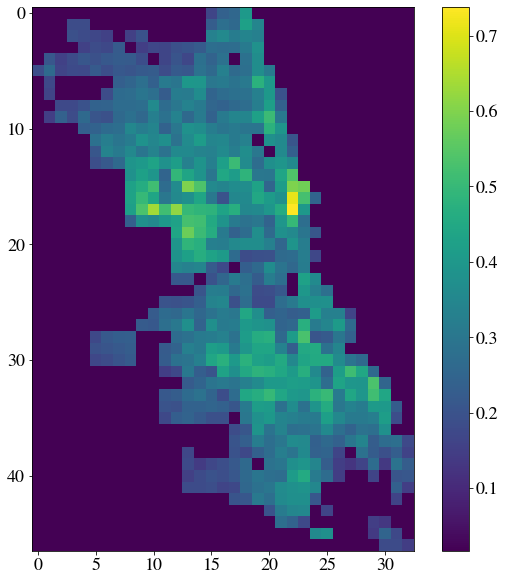

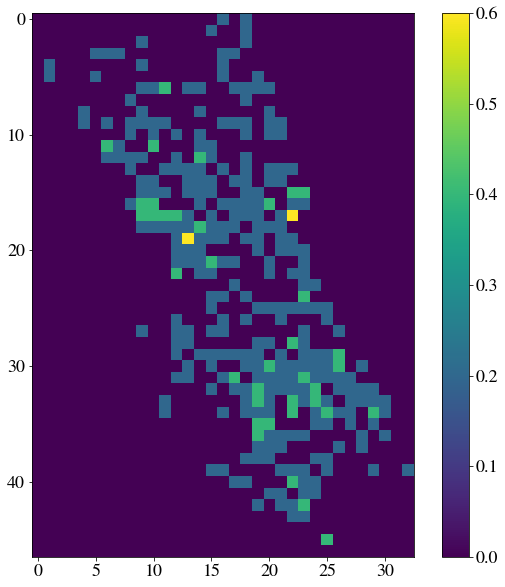

In [127]:
im(trn_probas_pred[:1, 0].mean(0))
im(trn_y_true[:1, 0].mean(0))

In [17]:
# have two values y_true_counts, y_true_class

In [115]:
if not conf.use_classification:
    trn_y_counts = np.copy(trn_y_true)
    trn_y_true[trn_y_true > 0] = 1

thresh = best_threshold(y_class=trn_y_true,
                        y_score=trn_probas_pred)

# thresholds = best_thresholds(y_true=trn_y_true,
#                              probas_pred=trn_probas_pred)


tst_y_true, tst_probas_pred, tst_t_range = evaluate_log_reg(model=model,
                                                            batch_loader=loaders.test_loader,
                                                            conf=conf)

tst_y_pred = get_y_pred(thresh, tst_probas_pred)
# tst_y_pred = get_y_pred_by_thresholds(thresholds, tst_probas_pred)    

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_y_pred = data_group.shaper.squeeze(tst_y_pred)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)

2020-08-24T15:15:03 | root | INFO | f1_score: 0.6702315928854259 at index 22059, new threshold 0.22889956831932068


In [116]:
save_metrics(y_count=tst_y_true,
             y_pred=tst_y_pred,
             y_score=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,
             conf=conf)

2020-08-24T15:15:08 | root | INFO | 
        MODEL METRICS
            Model Name: LR (CMP) (pad=3,seq_len=14) (HistAvg) (rgr)
                MAE:                0.434019228469908
                RMSE:               0.48895157091922026
                ROC AUC:            0.7370505058172541                
                Average Precision:  0.6849054115833654
                Precision:          0.5532760179093184
                Recall:             0.8498869874071683
                Accuracy:           0.6283717860422406
                MCC:                0.3214345080953329          
        


2020-08-24T15:15:09 | root | INFO | 
                                                 RMSE       MAE   ROC AUC  \
Model Name                                                                  
Periodic average                             0.572850  0.420800  0.780020   
Global Average                               0.572785  0.420775  0.779824   
Ind-Hawkes Model                             0.440396  0.367043  0.778644   
LR (CMP) (pad=0,seq_len=5) (HistAvg) (rgr)   0.195899  0.169594  0.756363   
LR (CMP) (pad=0,seq_len=1) (HistAvg) (rgr)   0.206745  0.180193  0.749977   
Hawkes General Model                         0.612081  0.438873  0.747493   
LR (CMP) (pad=3,seq_len=14) (HistAvg) (rgr)  0.488952  0.434019  0.737051   
Previous Time Step                           0.585714  0.420469  0.638872   
ST-RESNET                                    0.496794  0.493276  0.510287   
ST-RESNET-Extra                              0.497014  0.493700  0.504174   

                                      

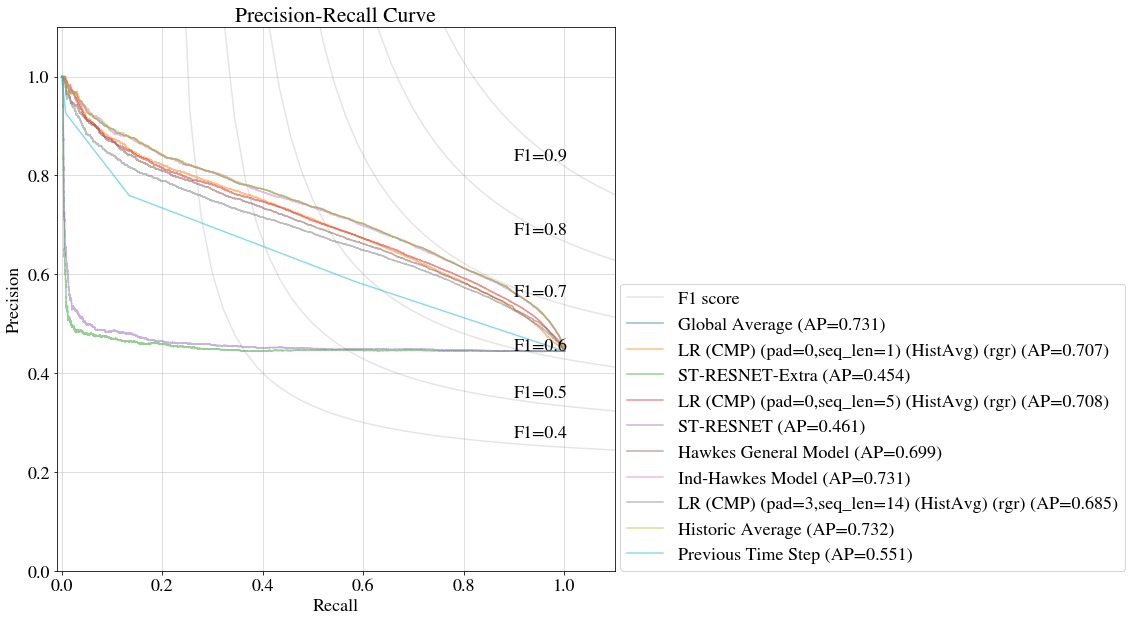

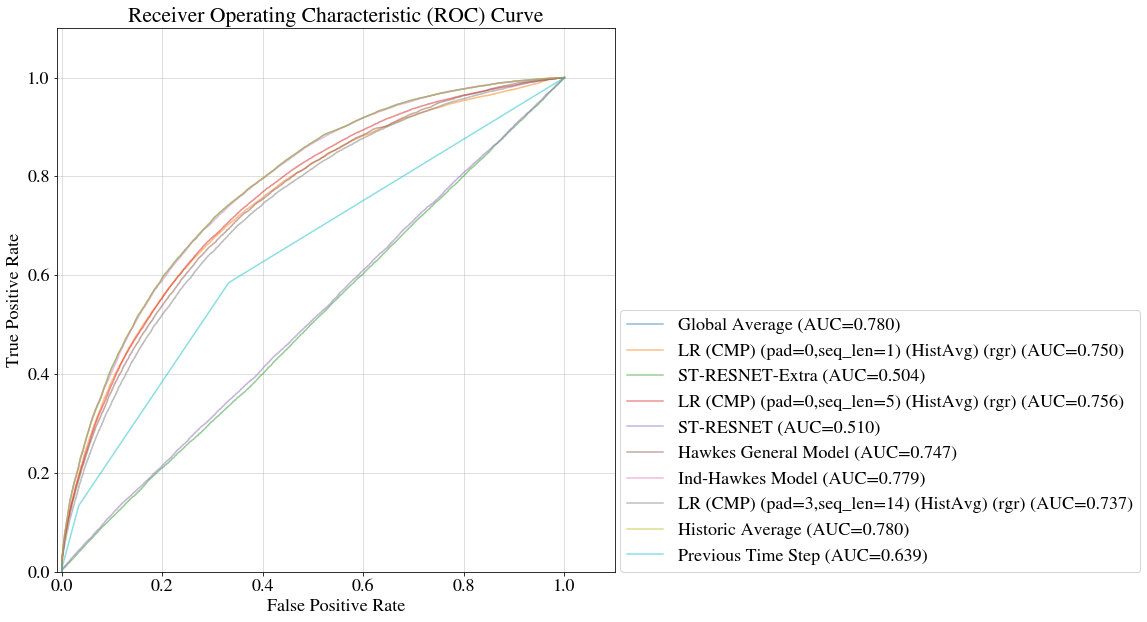

,RMSE,MAE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,,,
Periodic average,0.572850,0.420800,0.780020,0.732161,0.602188,0.824669,0.696084,0.680010,0.396018
Global Average,0.572785,0.420775,0.779824,0.731348,0.595091,0.840814,0.696928,0.675046,0.394007
Ind-Hawkes Model,0.440396,0.367043,0.778644,0.730800,0.601035,0.824992,0.695427,0.678891,0.394288
"LR (CMP) (pad=0,seq_len=5) (HistAvg) (rgr)",0.195899,0.169594,0.756363,0.708264,0.468577,0.982725,0.634578,0.497073,0.180346
"LR (CMP) (pad=0,seq_len=1) (HistAvg) (rgr)",0.206745,0.180193,0.749977,0.707295,0.455900,0.987730,0.623853,0.470730,0.118046
Hawkes General Model,0.612081,0.438873,0.747493,0.699312,0.570855,0.826865,0.675414,0.646852,0.342130
"LR (CMP) (pad=3,seq_len=14) (HistAvg) (rgr)",0.488952,0.434019,0.737051,0.684905,0.553276,0.849887,0.670232,0.628372,0.321435
Previous Time Step,0.585714,0.420469,0.638872,0.551308,0.444358,1.000000,0.615302,0.444358,0.000000
ST-RESNET,0.496794,0.493276,0.510287,0.461197,0.444444,0.996061,0.614637,0.444990,0.002690


In [117]:
from utils.metrics import plot_roc_and_pr_curve

compare_all_models(conf.data_path)

In [74]:
from utils.utils import describe_array

np.unique(tst_y_true.flatten(), return_counts=True)

(array([0. , 0.2, 0.4, 0.6, 0.8]), array([38726, 25511,  5189,   268,     2]))

ValueError: continuous format is not supported

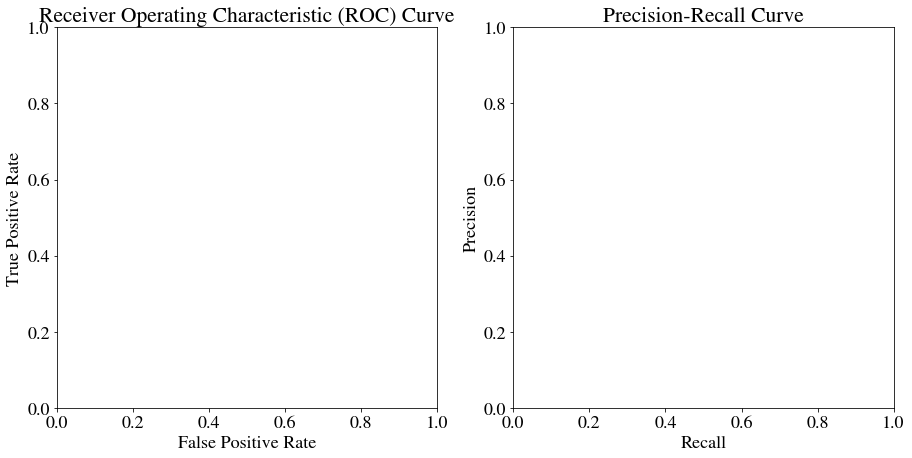

In [67]:
probas_pred_dict = {conf.model_name: tst_probas_pred.flatten()}
plot_roc_and_pr_curve(y_class=tst_y_true.flatten(), y_score_dict=probas_pred_dict)